# Composite Imaging Tutorial

<img src="lesson_images/final_composite_solution.jpg" width="300"/>

This notebook walks through a how to do composite imaging. **Composite imaging** is a technique where we combine two images. We will be working on compositing a subject image onto a background image.

What this will look like:
1. Load a subject image and a background image. Things to keep in mind: You want your subject image to ideally have a clear edge and can be easily cut out.
2. We are going to use an interactive masking script (`interactive_masking.py`) to draw a polygon mask. A polygon mask is a mask that is constructed from multiple edges. This will help cut out our subject from the background.
3. We will then add feathering (optional) to the mask to help blend the subject into the background.
4. We will use an interactive placement script (`interactive_placement.py`) to choose where the subject goes on the background and its scale. 
5. We will then blend the subject into the background with basic color adjustments.

### What your workspace looks like:
```
 04-Composites/
 ├── composite_tutorial.ipynb
 ├── interactive_masking.py
 ├── interactive_placement.py
 ├── composite_workflow/
 └── images/
     ├── car.jpeg
     ├── dog1.jpg
     ├── dog2.jpg
     ├── jungle.jpg
     └── nyc.jpg
```

Files to keep in mind:

* `interactive_masking.py` - This script will let you draw a polygon mask on the subject image.
* `interactive_placement.py` - This script will let you place the subject image on the background image.
* `composite_workflow/` - This folder will store all the intermediate files for the composite.

In [85]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Step 1: Load subject and background images

We will start by loading:

- A **subject** image.
- A **background** image.

You can swap these for other images by changing the file paths below.

In [86]:
# Image paths

subject_path = "images/car.jpeg"
background_path = "images/jungle.jpg"

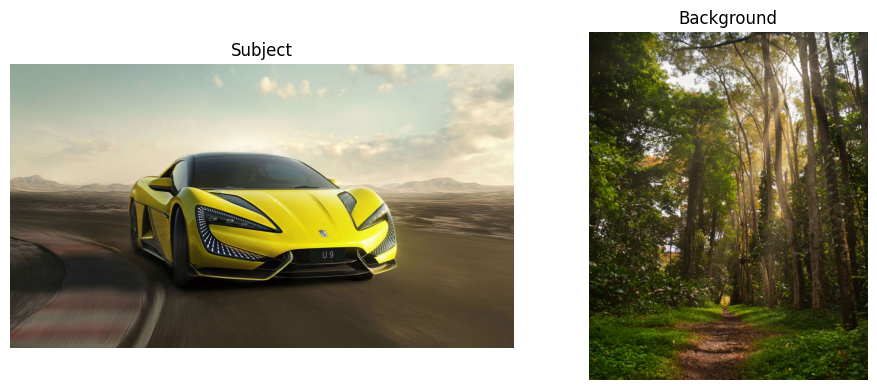

In [87]:
# STEP 1: Load subject and background images

# YOUR CODE HERE: display subject and background
subject = cv2.cvtColor(cv2.imread(subject_path), cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(cv2.imread(background_path), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(subject)
axes[0].set_title("Subject")
axes[0].axis("off")

axes[1].imshow(background)
axes[1].set_title("Background")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### Step 2: Interactive Masking

<img src='lesson_images/polygon_mask_preview.png' width='500'/>

To get a good subject cut-out, we will:

1. Save the subject image to a fixed path for the masking script.
2. Run `interactive_masking.py` from a terminal.
3. Draw a polygon around the subject in the OpenCV window.
4. Press **Enter** to save the mask.

#### Your Task:
1. Run the script and draw a polygon around the subject.
2. Save the mask and preview.

The script will save:
- `04-Composites/composite_workflow/polygon_mask.npy`
- `04-Composites/composite_workflow/polygon_mask_preview.png`

In [88]:
# Save subject for SOL_interactive_masking.py
subject_for_mask_path = "composite_workflow/subject_for_mask.png"

cv2.imwrite(subject_for_mask_path, cv2.cvtColor(subject, cv2.COLOR_RGB2BGR))
print(f"Saved subject for masking script to: {subject_for_mask_path}")
print("In a terminal, run:\n")
print("  python interactive_masking.py \\")
print("      --image composite_workflow/subject_for_mask.png \\")
print("      --output-mask composite_workflow/polygon_mask.npy \\")
print("      --output-preview composite_workflow/polygon_mask_preview.png")

Saved subject for masking script to: composite_workflow/subject_for_mask.png
In a terminal, run:

  python interactive_masking.py \
      --image composite_workflow/subject_for_mask.png \
      --output-mask composite_workflow/polygon_mask.npy \
      --output-preview composite_workflow/polygon_mask_preview.png


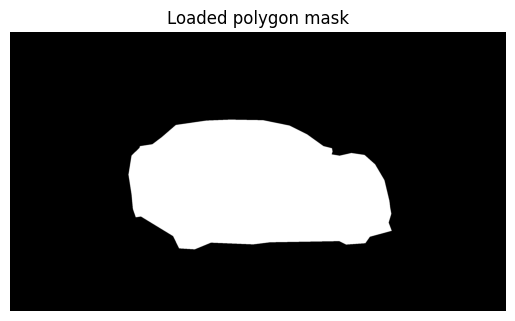

In [89]:
# STEP 3: Load the polygon mask produced by SOL_interactive_masking.py

mask_npy_path = 'composite_workflow/polygon_mask.npy'

poly_mask = np.load(mask_npy_path).astype(np.float32)

plt.imshow(poly_mask, cmap="gray")
plt.title("Loaded polygon mask")
plt.axis("off")
plt.show()

### Step 3: Feathering the Mask (optional)

<img src='lesson_images/refined_subject.png' width='500'/>

Feathering means softening the edges of the mask. This is optional, but it can help blend the subject into the background. 

Feathering is done by **blurring** the mask. We will save:

- `04-Composites/composite_workflow/refined_mask.npy`
- `04-Composites/composite_workflow/refined_subject.png`

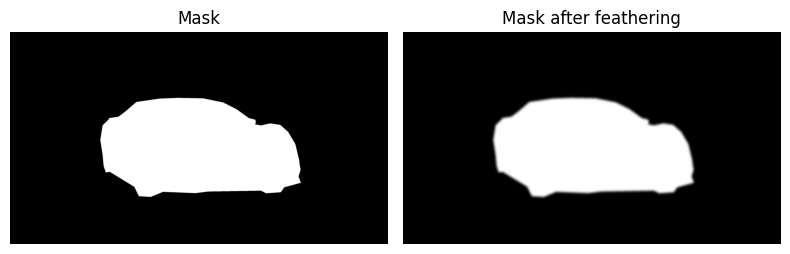

In [90]:
# Blur the cleaned mask and normalize it back to [0, 1].

feather_kernel_size = 51

# blur the mask using a blur kernel of size feather_kernel_size
# normalize the feathered mask to 0 to 1

refined_mask = cv2.GaussianBlur(poly_mask, (feather_kernel_size, feather_kernel_size), 0)
refined_mask = np.clip(refined_mask, 0, 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(poly_mask, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(refined_mask, cmap="gray")
plt.title("Mask after feathering")
plt.axis("off")

plt.tight_layout()
plt.show()

Saved refined mask to: composite_workflow/refined_mask.npy
Saved refined subject to: composite_workflow/refined_subject.png


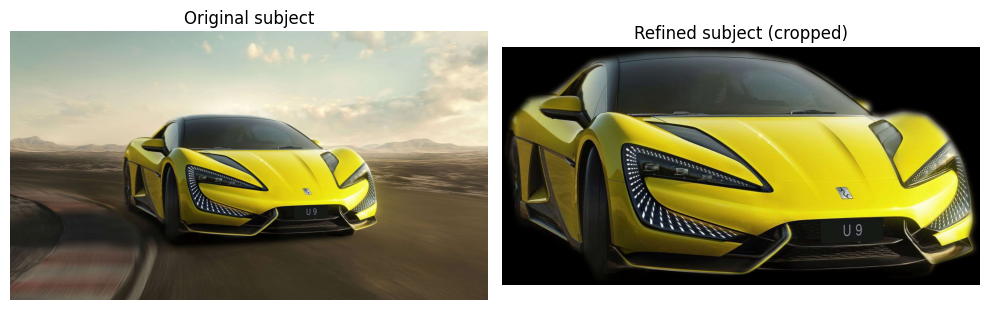

In [91]:
# MASKING THE SUBJECT
# build the cropped refined mask and subject
# Steps: Mask the image using a 3-channel version of refined_mask
# Then, find the edges of the mask and crop the image
# Store cropped mask in variable refined_mask_cropped
# Store cropped subject in variable refined_subject_bgr_cropped

refined_mask_cropped = subject * np.stack((refined_mask,refined_mask,refined_mask), axis=2)

refined_mask_cropped = refined_mask_cropped.astype(np.uint8)

def crop_black_borders(image):
    mask = np.sum(image, axis=2) > 0
    y_coords, x_coords = np.nonzero(mask)
    min_x = np.min(x_coords)
    max_x = np.max(x_coords)
    min_y = np.min(y_coords)
    max_y = np.max(y_coords)
    cropped_image = image[min_y:max_y+1, min_x:max_x+1]
    return cropped_image


refined_subject_bgr_cropped = cv2.cvtColor(crop_black_borders(refined_mask_cropped), cv2.COLOR_RGB2BGR)

refined_mask_path = "composite_workflow/refined_mask.npy"
refined_subject_path = "composite_workflow/refined_subject.png"

np.save(refined_mask_path, refined_mask_cropped.astype(np.float32))
cv2.imwrite(refined_subject_path, refined_subject_bgr_cropped)

print(f"Saved refined mask to: {refined_mask_path}")
print(f"Saved refined subject to: {refined_subject_path}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(subject)
plt.title("Original subject")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(refined_subject_bgr_cropped, cv2.COLOR_BGR2RGB))
plt.title("Refined subject (cropped)")
plt.axis("off")

plt.tight_layout()
plt.show()

### Step 4: Interactive placement

Now that we have a refined subject image, we will choose **where** it should appear in the background **and how large it should be**. We will do this via an interactive placement script called `interactive_placement.py`.

We will:

1. Save a copy of the background to a fixed path for the placement script.
2. Run `interactive_placement.py` from a terminal to drag the subject into place **and resize it**.
   * Click and drag to move the subject.
   * Press `+` / `=` to scale up, `-` to scale down, `r` to reset.
3. Save the chosen top-left `(y, x)` coordinates to `placement_info.npy`.

Your task:
1. Run the script and place the subject on the background.
2. Save the placement info.

The script will save:
- `04-Composites/composite_workflow/placement_info.npy`

In [92]:
# Save background for SOL_interactive_placement.py
background_for_place_path = "composite_workflow/background_for_composite.jpg"

cv2.imwrite(background_for_place_path, cv2.cvtColor(background, cv2.COLOR_RGB2BGR))
print(f"Saved background for placement script to: {background_for_place_path}")
print("In a terminal, run:\n")
print("  python interactive_placement.py \\")
print("      --subject composite_workflow/refined_subject.png \\")
print("      --background composite_workflow/background_for_composite.jpg \\")
print("      --output-placement composite_workflow/placement_info.npy")

Saved background for placement script to: composite_workflow/background_for_composite.jpg
In a terminal, run:

  python interactive_placement.py \
      --subject composite_workflow/refined_subject.png \
      --background composite_workflow/background_for_composite.jpg \
      --output-placement composite_workflow/placement_info.npy


In [93]:
placement_path = "composite_workflow/placement_info.npy"

placement_info = np.load(placement_path, allow_pickle=True).item()
place_y = int(placement_info["y"])
place_x = int(placement_info["x"])

print("Using placement (y, x):", (place_y, place_x))

Using placement (y, x): (1711, 263)


### Step 7: Composite the refined subject onto the background

<img src='lesson_images/composite_no_color.jpg' width='300'/>

We now have:

- `composite_workflow/refined_subject.png` – the cropped, refined subject with transparency.
- `composite_workflow/refined_mask.npy` – the refined (cropped) mask.
- `composite_workflow/placement_info.npy` – the chosen top-left `(y, x)` placement and scale for the subject.

In this step we will:

1. Load the refined subject, mask, and placement (including **scale**).
2. Resize the refined subject and mask according to the saved scale.
3. Alpha-blend the subject into the background using the refined mask.
4. Preview the composite.

In [94]:
# This section loads the cropped, refined subject image, its alpha mask, 
# and the placement (location + scale) information stored from previous steps.
# It resizes the subject and mask according to the chosen scale and prepares sub-regions for blending.
# After these steps, you have:
#   - The subject region to paste (in RGB, float32, [H, W, 3])
#   - The alpha mask region (float32, [H, W], in [0, 1])
#   - The background region where the subject will be pasted (in RGB, float32)

# Setup paths to important files
refined_subject_path = 'composite_workflow/refined_subject.png'
refined_mask_path = 'composite_workflow/refined_mask.npy'
placement_path = 'composite_workflow/placement_info.npy'

# Load the refined subject image, mask, and placement information.
refined_subj_bgr = cv2.imread(refined_subject_path, cv2.IMREAD_COLOR)
refined_mask_cropped = np.load(refined_mask_path).astype(np.float32)
placement_info = np.load(placement_path, allow_pickle=True).item()

# Get placement and scale info from placement_info dict.
place_y = int(placement_info["y"])
place_x = int(placement_info["x"])
scale = float(placement_info.get("scale", 1.0))  # Default to 1.0 if no scale

# Resize subject and mask to match requested scale
orig_h, orig_w = refined_subj_bgr.shape[:2]
# YOUR CODE HERE: resize refined_subj_bgr and refined_mask_cropped to match requested scale
new_h, new_w = int(orig_h * scale), int(orig_w * scale)
refined_subj_bgr_scaled = cv2.resize(refined_subj_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
refined_mask_scaled = cv2.resize(refined_mask, (new_w, new_h), interpolation=cv2.INTER_AREA)

# Convert images to float32 RGB in [0,1] for blending.
subj_rgb = cv2.cvtColor(
refined_subj_bgr_scaled, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
bg_rgb = background.astype(np.float32) / 255.0

# 1. Compute the background size, and subject size.
# 2. Clip the subject's placement to avoid running out of bounds.
# 3. Slice the appropriate regions from subject, alpha mask, and background.
# YOUR CODE HERE
subj_region_rgb = subj_rgb # region of subject to paste
mask_region = refined_mask_scaled # corresponding alpha mask region
bg_region_rgb = bg_rgb[place_y:int(place_y + orig_h * scale),place_x:int(place_x + orig_w * scale), :] # background region to blend into


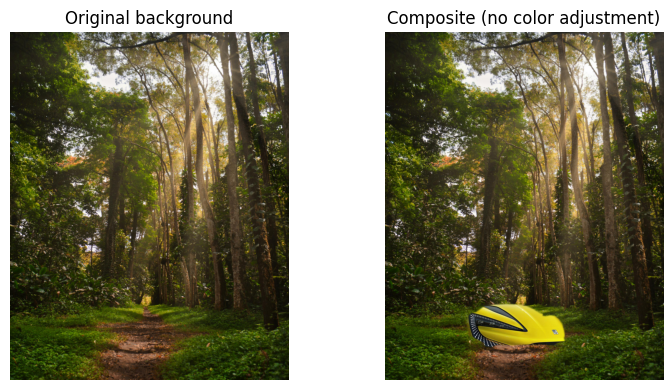

True

In [100]:
# This section is going to use the regions above to cut out the subject 
# and blend it into the backgroud.
# We do the following steps:
# 1. Create a 3-channel alpha mask from the refined mask to blend RGB images.
# 2. Copy the background to prepare for compositing.
# 3. Select the region of the background where the subject will be placed.
# 4. Blend the subject into that region using the mask as alpha: new_pixel = subject*alpha + background*(1-alpha).
# 5. Place the blended region back into the composite background image.

# Build a 3-channel transparency mask from the mask_region (should be range 0-1)
alpha_3c = np.stack((mask_region, mask_region, mask_region), axis=2)

composite_no_color_rgb = bg_rgb.copy()

# region_bg is the background region that we will blend the subject into
region_bg = composite_no_color_rgb[place_y:int(place_y + orig_h * scale),place_x:int(place_x + orig_w * scale), :]

# YOUR CODE HERE: blend the subject into the background using alpha_3c
blended_region = subj_region_rgb * alpha_3c + region_bg * (1 - alpha_3c)

# Replace the blended region in the composite
# YOUR CODE HERE
composite_no_color_rgb[place_y:int(place_y + orig_h * scale),place_x:int(place_x + orig_w * scale), :] = blended_region


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(background)
plt.title("Original background")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(composite_no_color_rgb)
plt.title("Composite (no color adjustment)")
plt.axis("off")

plt.tight_layout()
plt.show()

no_color_out_path = "composite_workflow/composite_no_color.jpg"
cv2.imwrite(no_color_out_path, cv2.cvtColor((composite_no_color_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))


### Step 8: Color-blend the subject with the background

<img src='lesson_images/final_composite_solution.jpg' width='300'/>

Now that we have a geometric composite with correct placement and size, we can make the subject **better match the lighting and color** of the background.

In this step we will:

* Compute color statistics only where the subject overlaps the background.
* Shift the subject colors toward the background colors using a tunable `color_blend_strength`.
* Visualize the subject region **before and after** color adjustment.
* Apply the color-adjusted subject back into the composite and save the final result.

In [ ]:
# STEP 8: Simple color blending on top of the geometric composite

# Tunable strength: 0 = no change, 1 = fully match background mean
color_blend_strength = 0.75
composite_base_rgb = composite_no_color_rgb

subject_pixels = mask_region > 0

subj_vals = subj_region_rgb[subject_pixels]
bg_vals = bg_region_rgb[subject_pixels]

subj_mean = subj_vals.mean(axis=0)
bg_mean = bg_vals.mean(axis=0)

# IMPLEMENT THE COLOR SHIFT HERE
# Goal: Calculate color shift between the mean color in the background and subject
# Then shift the subject colors by color_blend_strength * color_shift

# YOUR CODE HERE
adjusted_subj_region = None

# Blend adjusted subject into the no-color composite (similar to the no color blending 
# step above)
# YOUR CODE HERE
composite_rgb = None

# 4. Quick before/after composite view
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(composite_base_rgb)
plt.title("Before color blend")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(composite_rgb)
plt.title("After color blend")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save final composite
final_out_path = 'composite_workflow/final_composite_solution.jpg'
cv2.imwrite(final_out_path, cv2.cvtColor((composite_rgb * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
print(f"Saved final composite to: {final_out_path}")